# Import Requirements

In [1]:
from __future__ import division
import glob
import pandas as pd
import numpy as np
from itertools import combinations
from collections import Counter
import time
from scipy import stats
from scipy import interp
import math
import re
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
from functools import partial
from scipy.integrate import quad
%matplotlib inline

In [2]:
from sklearn.lda import LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn import cross_validation as cv
from sklearn import metrics

# Functions

In [3]:
def import_data(filepath):
    DF = pd.read_csv(filepath)
    C = ['Patient','Visit','DateOfVisit','Age','Gender','ART','VL','iVL','pVL',
     'CD4','iCD4','nCD4','CD8','iCD8','nCD8','TMHDS','VisitDate','GDS','Prot', 
     'AAPos','Coverage','A','R','N','D','C','Q','E','G','H','I','L','K','M',
     'F','P','S','T','W','Y','V']
    DF = DF[C]
    return DF

def slice_position(df, pos):
    m = df['AAPos'] == pos
    sliced_df = df[m]
    return sliced_df

def reformat_section(df):
    '''Must be a dataframe containing only 1 position'''
    pos = str(int(list(df.AAPos)[0]))
    AAs = ['A','R','N','D','C','Q','E','G','H','I',
           'L','K','M','F','P','S','T','W','Y','V']
    newnames_dict = {}
    for item in AAs:
        newnames_dict[item]= pos+item
    df_renamed = df.rename(columns = newnames_dict)
    df_renamed.drop(['AAPos','Coverage', 'Prot', 'DateOfVisit', 'VisitDate'], axis=1, inplace=True)
    return df_renamed
    
def reformat_dataframe(DF, tat_length):
    on_columns = ['Patient', 'Visit', 'Age', 'Gender', 'ART', 'VL','iVL', 'pVL', 'CD4', 'iCD4', 
                  'nCD4', 'CD8', 'iCD8', 'nCD8', 'TMHDS', 'GDS']
    start_df = slice_position(DF, 1)
    sklearn_df = reformat_section(start_df)
    for i in range(2,tat_length+1):
        pos_df = slice_position(DF, i)
        pos_df2 = reformat_section(pos_df)
        sklearn_df = pd.merge(sklearn_df, pos_df2,
                   left_on=on_columns,
                   right_on=on_columns,
                   how='outer')    
    return sklearn_df

def get_GDS_threshold(sklearn_df):
    sklearn_df['GDS_Threshold'] = sklearn_df['GDS'] > 0.5
    sklearn_df['GDS_Threshold'] = sklearn_df['GDS_Threshold'].astype(int)
    return sklearn_df


### DIVERSITY FILTERING RELATED FUNCTIONS ########################

def import_diversity_data(filepath):
    AAs = ['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V']
    div_DF = pd.read_csv(filepath)
    div_positions = [int(a) for a in Counter(div_DF.AAPos)]
    return div_positions

def diversityColumnConverter(div_positions):
    AAs = ['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V']
    keep_positions = []
    for i in div_positions:
        for aa in AAs:
            keep_positions.append(str(i)+(aa))
    return keep_positions

### PLOTTING FUNCTIONS ###########################################

def lda_plot(x1, x2, xlim, savepath):
    mpl.rc('font',family='Arial')
    kde1 = stats.gaussian_kde(x1)
    kde2 = stats.gaussian_kde(x2)
    fig, ax = plt.subplots(figsize=(7,4))
    
    x1_median = np.median(x1)
    x2_median = np.median(x2)
    globmin = min([min(x1),min(x2)])
    globmax = max([max(x1),max(x2)])   
    x_eval = np.linspace(globmin-2, globmax+2, num=200)
    ax.axvline(x1_median, color='firebrick', linestyle='--')
    ax.axvline(x2_median, color='steelblue', linestyle='--')
    
    ax.scatter(x1, np.zeros(x1.shape), color='firebrick',marker='|', s=200)
    ax.scatter(x2, np.zeros(x2.shape), color='steelblue',marker='|', s=200)
    ax.plot(x_eval, kde1(x_eval), color='firebrick', ls = '-')
    ax.plot(x_eval, kde2(x_eval), color='steelblue', ls = '-')
    ax.fill_between(x_eval, kde1(x_eval), color='firebrick', alpha = 0.1)
    ax.fill_between(x_eval, kde2(x_eval), color='steelblue', alpha = 0.1)
    ax.set_xlim(xlim)
    ax.set_ylim([0,0.9])

    ax.set_ylabel('Probability density',size=18, labelpad=10, weight='bold')
    ax.set_xlabel('Linear Discriminant',size=18, labelpad=10, weight='bold')
    ax.tick_params(axis='both',labelsize=14)

    ax.legend([mpl.patches.Patch(color='firebrick',alpha=0.1),
               mpl.patches.Patch(color='steelblue',alpha=0.1)],
               ['Impaired', 'Non-impaired'],
               loc=1, ncol=1, fancybox=False, frameon=False,
               fontsize=10)

    plt.tight_layout()
    plt.show()
    fig.savefig(savepath,
                format='png', dpi=300, bbox_inches='tight')

In [4]:
DF = import_data('/Users/greg/Desktop/FullNeuroIllumina/MergedData/NGS_GDS_abundance.csv') # import
sklearn_df = reformat_dataframe(DF, 101) # reformat
sklearn_df.fillna(sklearn_df.mean(), inplace=True) #fillna
sklearn_df = get_GDS_threshold(sklearn_df) # convert GDS to a threshold
print sklearn_df.shape

(72, 2037)


In [5]:
sklearn_df.head()

,Patient,Visit,Age,Gender,ART,VL,iVL,pVL,CD4,iCD4,...,101K,101M,101F,101P,101S,101T,101W,101Y,101V,GDS_Threshold
0,A0001,R09,59,Male,on,20,987,987,797,400,...,0.000000,0,0,0.000081,0.000244,0.000000,0.000163,0,0.00122,1
1,A0010,R08,59,Male,on,20,50,470,1167,448,...,0.000757,0,0,0.000000,0.004542,0.000000,0.000000,0,0.00000,1
2,A0013,R09,68,Male,on,20,144,39373,771,564,...,0.000000,0,0,0.000150,0.001201,0.000000,0.000000,0,0.00000,0
3,A0019,R12,46,Female,on,20,99,164020,1130,398,...,0.000000,0,0,0.989574,0.000000,0.001813,0.000000,0,0.00000,0
4,A0026,R09,55,Male,on,67859,100000,100000,137,36,...,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,0,0.00000,1


In [6]:
diversityDF = pd.read_csv('/Users/greg/Desktop/varCompDF.csv')
print diversityDF.shape
diversityDF[diversityDF.Position==33]

(101, 10)


,InterDiversity_x,IntraDiversity_x,Position,Total_x,Variants_x,InterDiversity_y,IntraDiversity_y,Total_y,Variants_y,TotalInterDiversity
32,1.157364,1.103157,33,29,"[('H', 29), ('C', 1)]",1,1.092974,28,"[('H', 28)]",1.091005


In [7]:
interdiversity_features = []
uniq_features1 = []
uniq_features2 = []

for i,row in diversityDF.iterrows():
    p, v1, v2 = row['Position'], row['Variants_x'], row['Variants_y']
    word1 = "".join(re.findall("[A-Z]", v1))
    word2 = "".join(re.findall("[A-Z]", v2))
    string = ''.join(set(word1+word2))
    if len(string) > 1:
        for s in string:
            interdiversity_features.append(str(p)+s)
            
    uniq_set1 = ''.join(set(word1)-set(word2))
    uniq_set2 = ''.join(set(word2)-set(word1))
    
    for u in uniq_set1:
        uniq_features1.append(str(p)+u)
    for u in uniq_set2:
        uniq_features2.append(str(p)+u)
    
print len(interdiversity_features)
print len(uniq_features1)
print len(uniq_features2)

373
95
48


In [8]:
sklearn_filter_df = sklearn_df[['GDS_Threshold']+interdiversity_features]
print sklearn_filter_df.shape
sklearn_filter_df.head()

(72, 374)


,GDS_Threshold,1E,1I,1M,1L,1N,1S,1W,2E,2D,...,100V,101G,101H,101L,101Q,101P,101S,101R,101T,101Y
0,1,0.000308,0.002337,0.565052,0.006934,0.000051,0.000848,0.416637,0.489224,0.001885,...,0.004466,0.511528,0.000041,0.000407,0.014435,0.000081,0.000244,0.467084,0.000000,0
1,1,0.000000,0.000000,0.584795,0.005848,0.000000,0.000000,0.403509,0.594118,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004542,0.993944,0.000000,0
2,0,0.001661,0.496678,0.282392,0.001661,0.000000,0.001661,0.209302,0.489256,0.284298,...,0.000889,0.000300,0.000000,0.002552,0.000300,0.000150,0.001201,0.989491,0.000000,0
3,0,0.000000,0.002020,0.526599,0.008081,0.000673,0.001347,0.452525,0.532215,0.005369,...,0.001812,0.000000,0.003173,0.000000,0.001360,0.989574,0.000000,0.001360,0.001813,0
4,1,0.000000,0.005988,0.589820,0.008982,0.000000,0.002994,0.389222,0.594595,0.003003,...,0.010654,0.000761,0.000761,0.003805,0.988584,0.000000,0.000000,0.000000,0.000000,0


In [9]:
def sklearn_prep_filter(df):   
    y = np.ravel(df['GDS_Threshold'])
    X = df.drop(['GDS_Threshold'], axis=1)
    return X, y

def bhatta_full(x1, x2):
    kde1 = stats.gaussian_kde(x1)
    kde2 = stats.gaussian_kde(x2)
    obj_fun = partial(dy_func, kde1, kde2)
    coeff = quad(obj_fun, -np.inf, np.inf)[0]
    hellinger_distance = math.sqrt(1 - coeff)
    return coeff, hellinger_distance
    
def dy_func(kde1, kde2, x):
    return np.sqrt(kde1(x)*kde2(x))

# Plot

/Users/greg/anaconda/lib/python2.7/site-packages/sklearn/lda.py:371: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/greg/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


(72, 373)
373
0.78


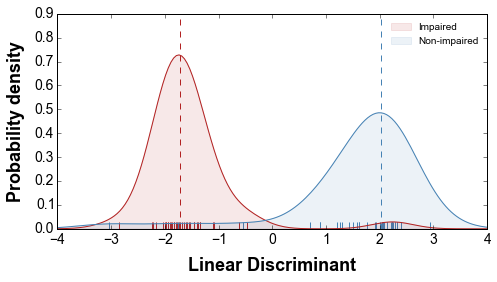

In [10]:
Xdf,y = sklearn_prep_filter(sklearn_filter_df)
X = Xdf.as_matrix()
#selector = VarianceThreshold()
#X = selector.fit_transform(X)

# LDA dimensional reduction
model = LDA(n_components=2, shrinkage=None)
X_transform = model.fit(X, y).transform(X)
print Xdf.shape
print len(model.coef_[0])
coeffs = model.coef_[0]
x1 = X_transform[y == 0, 0]
x2 = X_transform[y == 1, 0]

c,h = bhatta_full(x1,x2)
#print round(hellinger_dist,2)
print round(h,2)

# plot
lda_plot(x1,x2,[-4,4],'/Users/greg/Desktop/TatFigureStuff/lineardiscriminant373.png')

In [11]:
lda_dict = {'Feature':list(Xdf.columns), 'Coefficient':coeffs}
lda_df = pd.DataFrame(lda_dict)
lda_df['Unique1'] = lda_df['Feature'].apply(lambda x: x in uniq_features1)
lda_df['Unique2'] = lda_df['Feature'].apply(lambda x: x in uniq_features2)
lda_df['Position'] = lda_df['Feature'].apply(lambda x: x[:-1])
lda_df['AA'] = lda_df['Feature'].apply(lambda x: x[-1])
print lda_df.shape
lda_df.head()

(373, 6)


,Coefficient,Feature,Unique1,Unique2,Position,AA
0,-0.869393,1E,False,False,1,E
1,1.696298,1I,False,False,1,I
2,-1.830327,1M,False,False,1,M
3,5.432057,1L,True,False,1,L
4,3.588308,1N,True,False,1,N


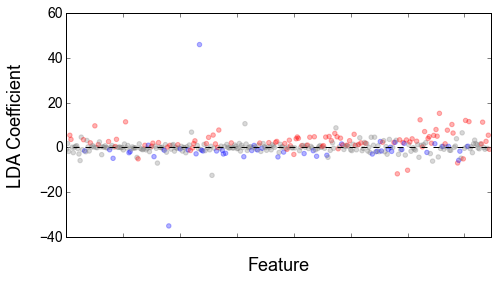

In [12]:
x = np.arange(len(lda_df['Coefficient']))

fig,ax = plt.subplots(figsize=(7,4))

color_list = []
for i,row in lda_df[['Coefficient','Position','AA','Feature','Unique1','Unique2']].iterrows():
    C = row.Coefficient
    P = str(row.Position)
    A = str(row.AA)
    U1 = row.Unique1
    U2 = row.Unique2
    F = row.Feature
    if U1:
        color_list.append('red')
    elif U2:
        color_list.append('blue')
        
    else:
        color_list.append('grey')
        
    #if not U1 and not U2 and abs(C) > 4: 
    #    ax.annotate(P+A, [i, C], size=12)

ax.hlines(0,-100,1000,linestyles='--')
ax.scatter(x,lda_df['Coefficient'], color = color_list, alpha=0.3)
ax.set_xlim(0,len(x))

ax.tick_params(axis='both', labelsize=14)
ax.set_xticklabels('')
ax.set_xlabel('Feature',size=18,labelpad=15)
ax.set_ylabel('LDA Coefficient',size=18,labelpad=15)

plt.tight_layout()
plt.show()
fig.savefig('/Users/greg/Desktop/TatFigureStuff/coefficients373.png',
            format='png', dpi=300, bbox_inches='tight')

/Users/greg/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/greg/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


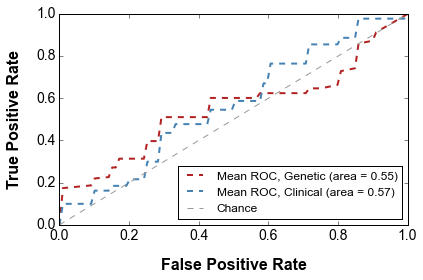

In [13]:
Xdf,y = sklearn_prep_filter(sklearn_filter_df)
X = Xdf.as_matrix()

folds=4
mean_tpr1 = 0.0
mean_fpr1 = np.linspace(0, 1, 100)
all_tpr1 = []
cvK = cv.KFold(n=X.shape[0], n_folds=folds)
for train_index, test_index in cvK:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    LDA_model = LDA(n_components=2)
    LDA_model.fit(X_train,y_train)
    score = LDA_model.score(X_test, y_test)
    probas_ = LDA_model.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = metrics.roc_curve(y_test, probas_[:, 1])
    mean_tpr1 += interp(mean_fpr1, fpr, tpr)
    mean_tpr1[0] = 0.0
    roc_auc = metrics.auc(fpr, tpr)

mean_tpr1 /= folds
mean_tpr1[-1] = 1.0
mean_auc1 = metrics.auc(mean_fpr1, mean_tpr1)




def sklearn_prep_clinical(df):   
    clin = ['Age', 'Gender', 'ART', 'VL','iVL', 'pVL','CD4','iCD4', 'nCD4', 'CD8', 'iCD8', 'nCD8']
    y = np.ravel(df['GDS_Threshold'])
    drop_cols = ['GDS_Threshold']
    X = df[clin]
    return X, y

Xclin, y = sklearn_prep_clinical(sklearn_df)
Xclin['Gender'] = Xclin['Gender'].apply(lambda x: int(x == 'Male'))
Xclin['ART'] = Xclin['ART'].apply(lambda x: int(x == 'on'))
X = Xclin.as_matrix()

folds=4
mean_tpr2 = 0.0
mean_fpr2 = np.linspace(0, 1, 100)
all_tpr2 = []
cvK = cv.KFold(n=X.shape[0], n_folds=folds)
for train_index, test_index in cvK:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    LDA_model = LDA(n_components=2)
    LDA_model.fit(X_train,y_train)
    score = LDA_model.score(X_test, y_test)
    probas_ = LDA_model.fit(X_train, y_train).predict_proba(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, probas_[:, 1])
    mean_tpr2 += interp(mean_fpr2, fpr, tpr)
    mean_tpr2[0] = 0.0
    roc_auc2 = metrics.auc(fpr, tpr)

mean_tpr2 /= folds
mean_tpr2[-1] = 1.0
mean_auc2 = metrics.auc(mean_fpr2, mean_tpr2)





mpl.rc('font',family='Arial')
fig,ax=plt.subplots(figsize=(6,4))
ax.plot(mean_fpr1, mean_tpr1, color='firebrick', ls='--',
         label='Mean ROC, Genetic (area = %0.2f)' % mean_auc1, lw=2)

ax.plot(mean_fpr2, mean_tpr2, color='steelblue', ls='--',
         label='Mean ROC, Clinical (area = %0.2f)' % mean_auc2, lw=2)  


ax.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Chance')
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlabel('False Positive Rate', size=16, labelpad=15, weight='bold')
ax.set_ylabel('True Positive Rate', size=16, labelpad=15, weight='bold')
ax.ticklabel_format(size=20)
ax.legend(loc="lower right")

plt.tight_layout()
fig.savefig('/Users/greg/Desktop/TatFigureStuff/rocauc373.png',
            format='png', dpi=300, bbox_inches='tight')
plt.show()

# No Filter

(72, 2020)
2020
0.7


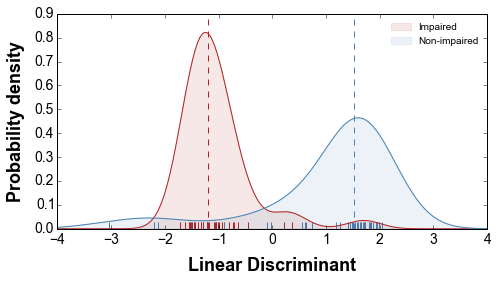

In [14]:
def sklearn_prep(df):   
    on_columns = ['Patient', 'Visit', 'Age', 'Gender', 'ART', 'VL','iVL', 'pVL',
                  'CD4','iCD4', 'nCD4', 'CD8', 'iCD8', 'nCD8', 'TMHDS', 'GDS']
    y = np.ravel(df['GDS_Threshold'])
    drop_cols = on_columns + ['GDS_Threshold']
    X = df.drop(drop_cols, axis=1)
    return X, y

Xdf, y = sklearn_prep(sklearn_df)
X = Xdf.as_matrix()
#selector = VarianceThreshold()
#X = selector.fit_transform(X)

# LDA dimensional reduction
model = LDA(n_components=2, shrinkage=None)
X_transform = model.fit(X, y).transform(X)
print Xdf.shape
print len(model.coef_[0])
coeffs = model.coef_[0]
x1 = X_transform[y == 0, 0]
x2 = X_transform[y == 1, 0]

c,h = bhatta_full(x1,x2)
#print round(hellinger_dist,2)
print round(h,2)

# plot
lda_plot(x1,x2,[-4,4],'/Users/greg/Desktop/TatFigureStuff/lineardiscriminant2020.png')

In [15]:
lda_dict = {'Feature':list(Xdf.columns), 'Coefficient':coeffs}
lda_df = pd.DataFrame(lda_dict)
lda_df['Unique1'] = lda_df['Feature'].apply(lambda x: x in uniq_features1)
lda_df['Unique2'] = lda_df['Feature'].apply(lambda x: x in uniq_features2)
lda_df['Position'] = lda_df['Feature'].apply(lambda x: x[:-1])
lda_df['AA'] = lda_df['Feature'].apply(lambda x: x[-1])
print lda_df.shape
lda_df.head()

(2020, 6)


,Coefficient,Feature,Unique1,Unique2,Position,AA
0,-11.215387,1A,False,False,1,A
1,6.521389,1R,False,False,1,R
2,0.132952,1N,True,False,1,N
3,12.062280,1D,False,False,1,D
4,-20.762158,1C,False,False,1,C


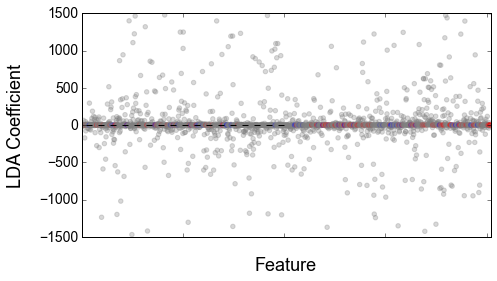

In [16]:
x = np.arange(len(lda_df['Coefficient']))

fig,ax = plt.subplots(figsize=(7,4))

color_list = []
for i,row in lda_df[['Coefficient','Position','AA','Feature','Unique1','Unique2']].iterrows():
    C = row.Coefficient
    P = str(row.Position)
    A = str(row.AA)
    U1 = row.Unique1
    U2 = row.Unique2
    F = row.Feature
    if U1:
        color_list.append('red')
    elif U2:
        color_list.append('blue')
        
    else:
        color_list.append('grey')
        
    #if not U1 and not U2 and abs(C) > 4: 
    #    ax.annotate(P+A, [i, C], size=12)

ax.hlines(0,-100,1000,linestyles='--')
ax.scatter(x,lda_df['Coefficient'], color = color_list, alpha=0.3)
ax.set_xlim(0,len(x))
ax.set_ylim(-1500,1500)

ax.tick_params(axis='both', labelsize=14)
ax.set_xticklabels('')
ax.set_xlabel('Feature',size=18,labelpad=15)
ax.set_ylabel('LDA Coefficient',size=18,labelpad=15)

plt.tight_layout()
plt.show()
fig.savefig('/Users/greg/Desktop/TatFigureStuff/coefficients2020.png',
            format='png', dpi=300, bbox_inches='tight')

/Users/greg/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/greg/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


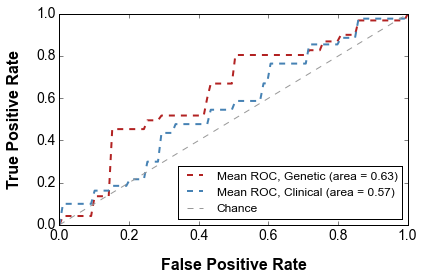

In [17]:
Xdf, y = sklearn_prep(sklearn_df)
X = Xdf.as_matrix()

folds=4
mean_tpr1 = 0.0
mean_fpr1 = np.linspace(0, 1, 100)
all_tpr1 = []
cvK = cv.KFold(n=X.shape[0], n_folds=folds)
for train_index, test_index in cvK:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    LDA_model = LDA(n_components=2)
    LDA_model.fit(X_train,y_train)
    score = LDA_model.score(X_test, y_test)
    probas_ = LDA_model.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = metrics.roc_curve(y_test, probas_[:, 1])
    mean_tpr1 += interp(mean_fpr1, fpr, tpr)
    mean_tpr1[0] = 0.0
    roc_auc = metrics.auc(fpr, tpr)

mean_tpr1 /= folds
mean_tpr1[-1] = 1.0
mean_auc1 = metrics.auc(mean_fpr1, mean_tpr1)




def sklearn_prep_clinical(df):   
    clin = ['Age', 'Gender', 'ART', 'VL','iVL', 'pVL','CD4','iCD4', 'nCD4', 'CD8', 'iCD8', 'nCD8']
    y = np.ravel(df['GDS_Threshold'])
    drop_cols = ['GDS_Threshold']
    X = df[clin]
    return X, y

Xclin, y = sklearn_prep_clinical(sklearn_df)
Xclin['Gender'] = Xclin['Gender'].apply(lambda x: int(x == 'Male'))
Xclin['ART'] = Xclin['ART'].apply(lambda x: int(x == 'on'))
X = Xclin.as_matrix()

folds=4
mean_tpr2 = 0.0
mean_fpr2 = np.linspace(0, 1, 100)
all_tpr2 = []
cvK = cv.KFold(n=X.shape[0], n_folds=folds)
for train_index, test_index in cvK:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    LDA_model = LDA(n_components=2)
    LDA_model.fit(X_train,y_train)
    score = LDA_model.score(X_test, y_test)
    probas_ = LDA_model.fit(X_train, y_train).predict_proba(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, probas_[:, 1])
    mean_tpr2 += interp(mean_fpr2, fpr, tpr)
    mean_tpr2[0] = 0.0
    roc_auc2 = metrics.auc(fpr, tpr)

mean_tpr2 /= folds
mean_tpr2[-1] = 1.0
mean_auc2 = metrics.auc(mean_fpr2, mean_tpr2)





mpl.rc('font',family='Arial')
fig,ax=plt.subplots(figsize=(6,4))
ax.plot(mean_fpr1, mean_tpr1, color='firebrick', ls='--',
         label='Mean ROC, Genetic (area = %0.2f)' % mean_auc1, lw=2)

ax.plot(mean_fpr2, mean_tpr2, color='steelblue', ls='--',
         label='Mean ROC, Clinical (area = %0.2f)' % mean_auc2, lw=2)  


ax.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Chance')
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlabel('False Positive Rate', size=16, labelpad=15, weight='bold')
ax.set_ylabel('True Positive Rate', size=16, labelpad=15, weight='bold')
ax.ticklabel_format(size=20)
ax.legend(loc="lower right")

plt.tight_layout()
fig.savefig('/Users/greg/Desktop/TatFigureStuff/rocauc2020.png',
            format='png', dpi=300, bbox_inches='tight')
plt.show()